# Getting to know qubits through QEC

### James R. Wootton, IBM Quantum

## Introduction

Back in 2018 I worked as a quantum error correction researcher at the University of Basel. IBM had just put a 16 qubit device online, and I wanted to see how well it could implement the basics of QEC. So I ran repetition codes.


* *James R. Wootton and Daniel Loss Phys. Rev. A 97, 052313 (2018)*

The main aim was to run codes of varying sizes, to test the idea that logical errors are suppressed with increasing code size. Here are the results from that 16 qubit device, which at that time was called *ibmqx3*.

<img src="images/ibmqx3-decay.png" alt="" width="700"/>

Here the points show the probability of a logical error for different codes. The *partial decoding* is a simple majority voting of the final results of the code qubits. The *full decoding* takes the full set of results into account.

The points here decrease in a manner that is a but bumpy, but largely linear. Note that the y axis is logarithmic. The results are therefore consistent with the logical error decreasing exponentially with code size.




After a few months, the device was taken out of the fridge for a while and cooled down again. It's name changed to *ibmqx5* and its behaviour changed also.

<img src="images/ibmqx5-decay.png" alt="" width="700"/>

Note the uptick of the partial decoding, which shows that something is not right.

To see what is going on, we can look at a different kind of graph. For each qubit, what is the probability that it ends up in the `1` state?

For *ibmqx3*, the results looked like the following.

<img src="images/ibmqx3-1.png" alt="" width="900"/>

As more qubits are added in to the code, more get affected by the additional noise. But for those already in the code, the noise they experience appears to be the same. This is what we might expect from the repetition code, since the circuit experienced by any qubit is not affected by qubits far away.

Now let's take a look at *ibmqx5* instead.

<img src="images/ibmqx5-1.png" alt="" width="910"/>

In going from `d=7` to `d=8`, qubits 13 and 14 are added to the code. But the effects go far beyond just these. Many qubits are hit with a huge amount of noise, all the way down to qubit 9.

This is what causes the uptick seen earlier, where increasing code size does not lead to less logical errors. It shows that the method used to make this device is not good enough to support large-scale quantum error correction. Because of problems such as this, IBM rethought how they arranged their qubits. And it was independently discovered by me, an external researcher running repetition codes.

So what remains for us to discover in 2021?

## Repetiton codes with Qiskit

Now let's make some repetition codes with Qiskit. We'll need `QuantumCircuit` objects, and `QuantumRegister` and `ClassicalRegister` objects.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

We'll also need too decide how big we want the code to be. Specifcially, the number of repetitions `d` and the number of syndrome measurement rounds `T`.

To be able to see the circuits easily, we'll start with the minimum for `d`.

In [2]:
d = 3

Let's also increase the value of `T` as we add measurement rounds to the circuit. So since we start with none...

In [3]:
T = 0

We start with an empty circuit

In [4]:
qc = QuantumCircuit()

then we add `d` code qubits

In [5]:
code_qubit = QuantumRegister(d, 'code_qubit')
qc.add_register( code_qubit )

and `d-1` auxilliary qubits.

In [6]:
link_qubit = QuantumRegister(d-1, 'link_qubit')
qc.add_register( link_qubit )

Then what we have is a `d=3`, `T=0` code for an encoded logical `0`. Which is still basically an empty circuit.

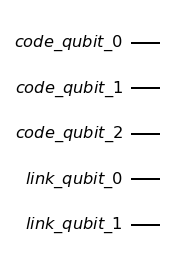

In [7]:
qc.draw(output='mpl')

Now we can add the `cx` gates required for each syndrome measurement round. Each time this cell is run, it iterates `T` by 1.

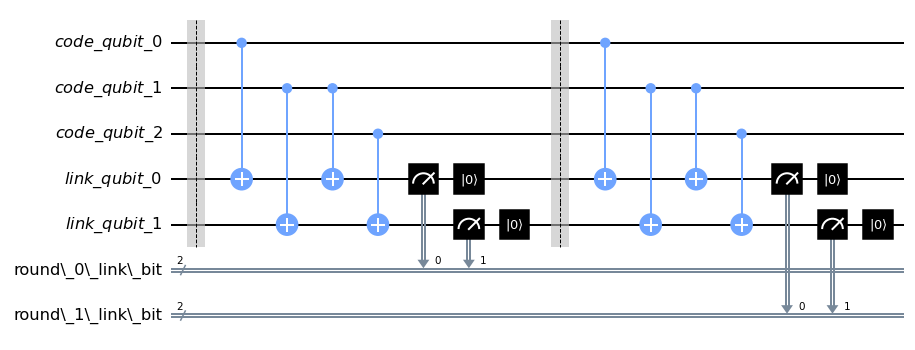

In [9]:
qc.barrier()

# for each link qubit, add a cx for the code qubit on one side
for j in range(d-1):
    qc.cx(code_qubit[j],link_qubit[j])
        
# and then one for the other side
for j in range(d-1):
    qc.cx(code_qubit[j+1],link_qubit[j])
    
# add a classical register to hold results from this round
link_bit = ClassicalRegister(d-1, 'round_'+str(T)+'_link_bit')
qc.add_register(link_bit)

# measure and then rest each link qubit to extract the syndrome
for j in range(d-1):
    qc.measure(link_qubit[j],link_bit[j])
    qc.reset(link_qubit[j])
        
# iterate the number of rounds
T += 1
    
qc.draw(output='mpl') # uncomment to draw circuit

In [10]:
T

2

Then we add the final readout of the code qubits.

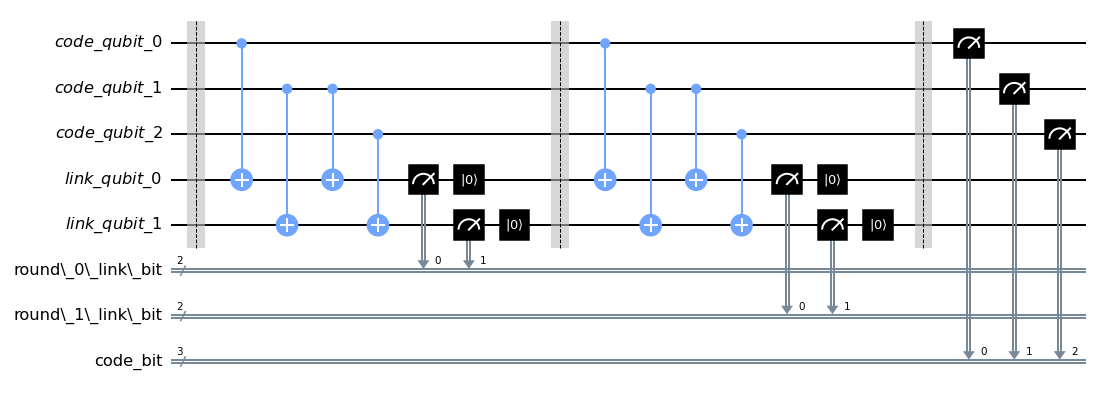

In [11]:
qc.barrier()

# add d bits for final readout of code qubits
code_bit = ClassicalRegister(d, 'code_bit')
qc.add_register(code_bit)

# measure code qubits
for j in range(d):
    qc.measure(code_qubit[j],code_bit[j])
    
qc.draw(output='mpl') # uncomment to draw circuit

Now we have a code, we need a backend to run it on. We'll start with just a simulator.

First we get the backend object for the simulator.

In [12]:
from qiskit import Aer

backend_sim = Aer.get_backend('aer_simulator')

Then we use this to start the process of running the circuit, by creating the job object.

In [13]:
job = backend_sim.run(qc)

Once the job has run, we extract the result object from this.

In [14]:
result = job.result()

From this we can get our actual result: a histogram respresented as a Python dictionary.

In [15]:
counts = result.get_counts()
counts

{'000 00 00': 1024}

To see what happens when errors occur, let's manually insert some. Here are some circuits I made earlier.

In [16]:
examples_qasm = ['OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nx code_qubit[0];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nx code_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\nx code_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nx link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n', 'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg code_qubit[3];\nqreg link_qubit[2];\ncreg round_0_link_bit[2];\ncreg round_1_link_bit[2];\ncreg code_bit[3];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nmeasure link_qubit[0] -> round_0_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_0_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\ncx code_qubit[0],link_qubit[0];\ncx code_qubit[1],link_qubit[1];\ncx code_qubit[1],link_qubit[0];\ncx code_qubit[2],link_qubit[1];\nx link_qubit[1];\nmeasure link_qubit[0] -> round_1_link_bit[0];\nreset link_qubit[0];\nmeasure link_qubit[1] -> round_1_link_bit[1];\nreset link_qubit[1];\nbarrier code_qubit[0],code_qubit[1],code_qubit[2],link_qubit[0],link_qubit[1];\nmeasure code_qubit[0] -> code_bit[0];\nmeasure code_qubit[1] -> code_bit[1];\nmeasure code_qubit[2] -> code_bit[2];\n']

examples = []
for qasm in examples_qasm:
    examples.append(QuantumCircuit.from_qasm_str(qasm))

The errors seen here are the following.

* 0: Initialization error on `code_qubit[0]`
* 1: Error on `code_qubit[0]` while idle during first round of measurements.
* 2: Error on `code_qubit[0]` while idle during second round of measurements.
* 3: Initialization error on `code_qubit[1]`
* 4: Error on `code_qubit[1]` while idle during first round of measurements.
* 5: Error on `code_qubit[1]` while idle during second round of measurements.
* 6: Error on `code_qubit[1]` between `cx` gates of first syndrome measurement.
* 7: Measurement error on `link_qubit[1]` during first round of measurements.
* 8: Measurement error on `link_qubit[1]` during second round of measurements.

Let's take a look at each circuit

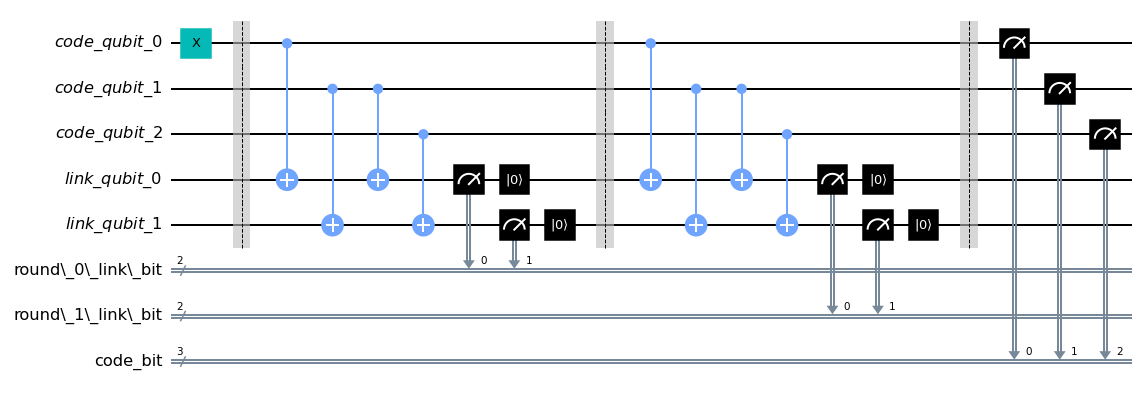

In [17]:
example = examples[0]
example.draw(output='mpl')

and the effect that it has

In [18]:
job = backend_sim.run(example)
counts = job.result().get_counts()
print(counts)

{'001 01 01': 1024}


These results have two parts:
* On the left, a `d`-bit string of the final code qubit readouts;
* On the right, `T` lots of `d-1`-bit strings of the syndrome measurement readouts (with the rightmost being the first).

The final code qubit readouts tell us two important things:
* A final syndrome measuremement (inferred from comparing bit values);
* The value of the logical bit.

It therefore makes sense to process the result a bit to separate out these aspects.

In [19]:
def process_1(output):
    
    output = output.split(' ')
    logical = output[0][0]+' '+output[0][-1]

    final = ''
    for j in range(d-1):
        if output[0][j]==output[0][j+1]:
            final += '0'
        else:
            final += '1'
    output[0] = final     
    
    output = logical + '  ' + ' '.join(output)
    
    return output

output = list(counts.keys())[0]
process_1(output)

'0 1  01 01 01'

Here the processed output again has two parts:
* On the left, two opinions on what the logical bit value is (taken from the code qubits at each end of the code);
* On the right `T+1` lots of `d-1`-bit strings of the syndrome measurement readouts (including the inferred one from the final readout.

If you are wondering why we take two opinions on the logical readout: it's because it will make things nice later.

As we saw in the lecture, it is not actually the syndrome values themselves that are useful, but it is their changes. So there's some more processing we can do, to output the syndrome changes instead of the values themselves.

In [20]:
def process_2(output):
    
    output = output.split('  ')
    logical = output[0]
    syndrome = output[1].split(' ') [::-1]  
    
    changes = [syndrome[0]]
    for t in range(T):
        change = ''
        for j in range(d-1):
            if syndrome[t][j]==syndrome[t+1][j]:
                change += '0'
            else:
                change += '1'
        changes.append(change)
    
    output = logical + '  ' + ' '.join(changes[::-1])
    
    return output

process_2(process_1(output))

'0 1  00 00 01'

Now let's take a look at the effect on all the examples.

In [21]:
example = examples[0]

job = backend_sim.run(example)
counts = job.result().get_counts()

output = list(counts.keys())[0]
process_2(process_1(output))

'0 1  00 00 01'

Each inserted single qubit error results in a pair of syndrome changes, or one syndrome change and one logical value change. Either way, a unique pair of changes happen depending on exactly where and when the error happened. It is this that allows us to figure out what errors occurred, and how to correct them.

## Repetition Codes with `topological_codes`

Though it was good for us to see how to create repetition codes manually, the process is automated using `topological_codes` within Qiskit.

In [22]:
!pip uninstall qiskit-ignis --yes

Found existing installation: qiskit-ignis 0.7.0
Uninstalling qiskit-ignis-0.7.0:
  Successfully uninstalled qiskit-ignis-0.7.0


In [23]:
!pip install git+https://github.com/Qiskit/qiskit-ignis.git


  Cloning https://github.com/Qiskit/qiskit-ignis.git to /private/var/folders/cy/l3sn56xs1ms8c3mkn7p266s80000kp/T/pip-req-build-oc6qbivr
  Created wheel for qiskit-ignis: filename=qiskit_ignis-0.7.0-py3-none-any.whl size=199922 sha256=bf5fe41448b12add3857924fa3018e8f5a65cb45c3d796aa24e9c6ed725e45d2
  Stored in directory: /private/var/folders/cy/l3sn56xs1ms8c3mkn7p266s80000kp/T/pip-ephem-wheel-cache-2171_1bu/wheels/ee/09/af/1448694efdbab6cb2fe3c911a8dca195779ef62f0505869e38
Successfully built qiskit-ignis
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit 0.26.2 requires qiskit-ignis==0.6.0, but you have qiskit-ignis 0.7.0 which is incompatible.
qiskit-aqua 0.9.1 requires qiskit-ignis<0.7.0,>=0.6.0, but you have qiskit-ignis 0.7.0 which is incompatible.


In [24]:
from qiskit.ignis.verification.topological_codes import RepetitionCode

We can create a repetition code object using

In [25]:
d = 3
T = 2

code = RepetitionCode(d,T,resets=True)

In this we have `code.circuit['0']` which contains the circuit for a stored logical `0`, like the one we just created.

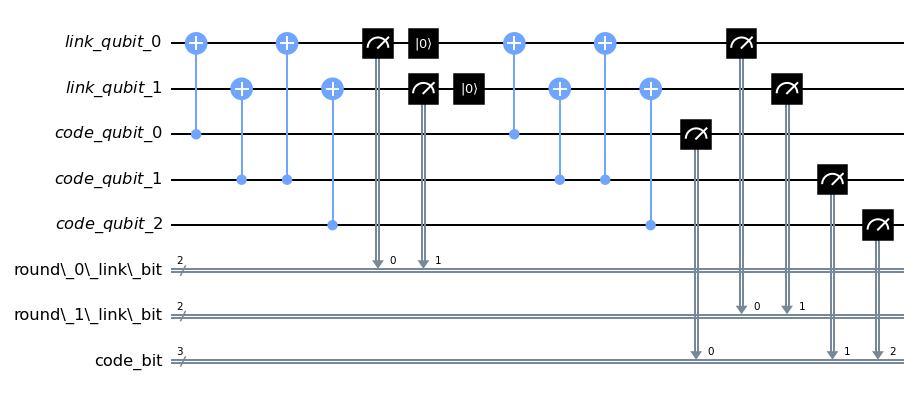

In [26]:
code.circuit['0'].draw(output='mpl')

And there's also one for a stored logical `1`.

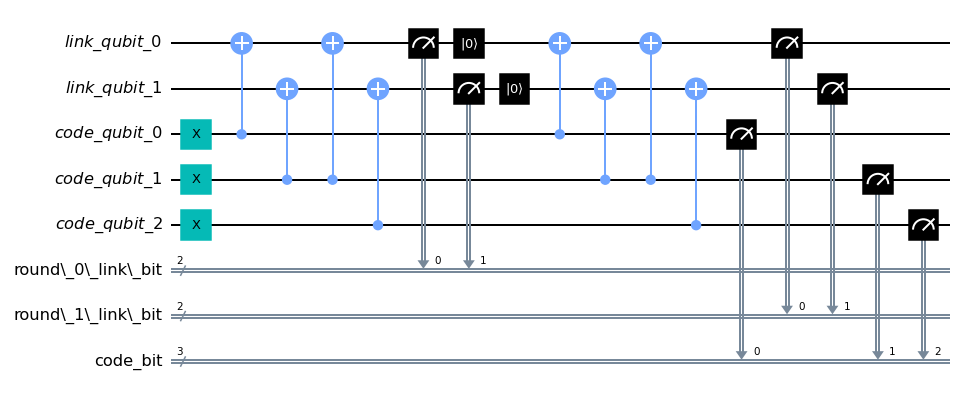

In [27]:
code.circuit['1'].draw(output='mpl')

Let's combine these into a list and run them in the same job

In [28]:
job = backend_sim.run([code.circuit['0'], code.circuit['1']])

and then put the results together in the same dictionary

In [29]:
raw_results = {'0':job.result().get_counts(code.circuit['0']), '1':job.result().get_counts(code.circuit['1'])}
raw_results

{'0': {'000 00 00': 1024}, '1': {'111 00 00': 1024}}

Since there are no errors, the results aren't very interesting. Just the standard code qubit readout on the left (all reflecting the logical value), and syndrome values on the right (detecting no errors).

However, interesting or not, the code object allows us to process the results in the manner discussed earlier.

In [30]:
results = code.process_results(raw_results)
results

{'0': {'0 0  00 00 00': 1024}, '1': {'1 1  00 00 00': 1024}}

To get some more interesting results, we can run the code on real quantum hardware. For that we need to load our IBMQ account.

In [31]:
from qiskit import IBMQ
provider = IBMQ.load_account()

We'll use a suitable device: the 5 qubit `'ibmq_manila'`.

In [32]:
backend = provider.get_backend('ibmq_manila')

With some fancy Jupyter tools, we can take a look at it and its properties.

In [33]:
import qiskit.tools.jupyter
backend

<IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>

Before running on this device, we need to transpile the circuit. This means rewriting it purely in terms of the gates that the device can directly use. For this we use Qiskit's `transpile` command.

In [34]:
from qiskit import transpile

transpiled_circuits = {
    bit:transpile(code.circuit[bit], backend=backend) for bit in ['0','1']
}

Let's take a look at how the circuit has changed, the original had the following number of each type of gate

In [35]:
code.circuit['0'].count_ops()

OrderedDict([('cx', 8), ('measure', 7), ('reset', 2)])

For the transpiled circuit, these numbers have changed

In [36]:
transpiled_circuits['0'].count_ops()

OrderedDict([('cx', 13), ('measure', 7), ('reset', 2), ('barrier', 1)])

For some reason, the transpilation has increased the number of `cx` gates. To see why, we can use the `qubits` attribute of a circuit to see what order it considers its qubits to be in.

In [37]:
code.circuit['0'].qubits

[Qubit(QuantumRegister(2, 'link_qubit'), 0),
 Qubit(QuantumRegister(2, 'link_qubit'), 1),
 Qubit(QuantumRegister(3, 'code_qubit'), 0),
 Qubit(QuantumRegister(3, 'code_qubit'), 1),
 Qubit(QuantumRegister(3, 'code_qubit'), 2)]

This means that it will initially try to use qubit 0 on the device as `link_qubit[0]`, qubit 1 as `link_qubit[1]`, qubit 3 as `code_qubit[0]` and so on. But this presents a problem. The circuit needs to do a `cx` between `code_qubit[0]` and `link_qubit[0]`, and so will try to do one between qubits 0 and 2 of the device. But the device does not allow such `cx` gates, and so it will have to do some tricks to create an effective `cx` gate between these two. It's these tricks that require more `cx` gates to be added.

In this case, we don't actually require the tricks. In fact, we actively don't want them. We want to know exactly which qubit on the device is doing which job, so we can get some insight about their errors. We don't want strange transpilation confusing things.

To solve this issue we can tell the transpiler which qubit should be doing which job. Our circuit will work fine if the qubits are given jobs as follows.

```
qubit on device           0 ------------- 1 ------------- 2 ------------- 3 ------------- 4

qubut in circuit    code_qubit[0] - link_qubit[0] - code_qubit[1] - link_qubit[1] - code_qubit[2]

```

So we make an `initial_layout` telling this information to the transpiler, listing the qubits on the device in the order of the `qubits` list above.

In [38]:
initial_layout = [
    1,
    3,
    0,
    2,
    4
]

transpiled_circuits = {
    bit:transpile(code.circuit[bit], backend=backend, initial_layout=initial_layout) for bit in ['0','1']
}

transpiled_circuits['0'].count_ops()

OrderedDict([('cx', 8), ('measure', 7), ('reset', 2)])

Now we are ready to send the job.

In [48]:
job = backend.run([transpiled_circuits['0'], transpiled_circuits['1']], shots=8192)

As soon as it is sent, we can get the job id.

In [49]:
job.job_id()

'616d56cb7c5dd5fb88fd162e'

You won't need to use the next cell, since you are running the job live. But I'm retreiving the job I ran when preparing this notebook, which can be done with the job id.

In [75]:
#job = backend.retrieve_job('616d56cb7c5dd5fb88fd162e')

This won't work for you, though. You'll need to submit your own jobs and get your own job ids.

Once the job has run, we can extract the raw results. Here we'll see more than just the simple case with no errors.

In [76]:
raw_results = {
    '0':job.result().get_counts(transpiled_circuits['0']),
    '1':job.result().get_counts(transpiled_circuits['1'])
}

#raw_results # uncomment to see results

Let's process these results to see the syndrome changes.

In [77]:
results = code.process_results(raw_results)
#results # uncomment to see results

Here we can see that the most likely outcome is the one that represents no errors. Then there are many that represent a single bit flip error somewhere, which we see from the fact that there are two syndrome changes. Then there are less likely cases with more than one error.

One way we can process this data to get an idea of what is happening on the device is to calculate the logical error probability. This goes through all the different results, runs decoding to see what the most likely encoded value is for that result, and then compares that to what the encoded value is known to be.

To run decoding, we need the decoder object for the code.

In [78]:
from qiskit.ignis.verification.topological_codes import GraphDecoder

decoder = GraphDecoder(code)

Then we simply feed in the results to its `get_logical_prob` method.

In [79]:
decoder.get_logical_prob(results)

{'0': 0.0023193359375, '1': 0.0955810546875}

Typically we find that the logical error probability is much worse for an encoded `1`, due to the fact that bit flips are much more likely to flip `1`s to `0`s than vice-versa.

To get a more detailed picture of life on the device, we can also look at the probabiity for specific error processes. Though the decoder gives us a way to calculate this, let's do it manually instead. Specifically, we'll do it for all the example errors.

First we'll collect the outputs that are a signature of those single errors.

In [80]:
example_outputs = []

for example in examples:

    job = backend_sim.run(example)
    counts = job.result().get_counts()
    output = list(counts.keys())[0]
    processed_output = process_2(process_1(output))
    
    example_outputs.append(processed_output)
    
example_outputs

['0 1  00 00 01',
 '0 1  00 01 00',
 '0 1  01 00 00',
 '0 0  00 00 11',
 '0 0  00 11 00',
 '0 0  11 00 00',
 '0 0  00 10 01',
 '0 0  00 10 10',
 '0 0  10 10 00']

Since we are just running small codes, it's not unlikely to see runs where only these single errors occur. By just looking at how many times these single errors occur, we can see their relative likelihood. Here we'll calculate these relative to the first example.

In [81]:
def get_ratios(results, logical='0'):
    
    probs = {}
    
    for output in example_outputs:
        if output in results[logical]:
            probs[output] = results[logical][output]/results[logical][example_outputs[0]]
        else:
            probs[output] = 0.0
            
    return probs
    
get_ratios(results)

{'0 1  00 00 01': 1.0,
 '0 1  00 01 00': 1.6923076923076923,
 '0 1  01 00 00': 1.3846153846153846,
 '0 0  00 00 11': 1.9230769230769231,
 '0 0  00 11 00': 2.1153846153846154,
 '0 0  11 00 00': 5.576923076923077,
 '0 0  00 10 01': 0.23076923076923078,
 '0 0  00 10 10': 1.5769230769230769,
 '0 0  10 10 00': 3.5384615384615383}

Here each error process is referred to by a pair of coordinates, which aren't very easy to understand at first glance. These coordinates refer to where the two syndrome changes are for this particular type of error.

To get a better idea of what these mean, we can go through all the example errors from earler and find their coordinates.

Now let's look at a different implementation of the `d=3`, `T=2` code for comparison. This time we'll remove the `reset` gates. These are pretty slow things to have in the middle of a circuit. They aren't really needed either, since their job can be done in post-processing.

In [82]:
code_no_resets = RepetitionCode(d,T,resets=False)

transpiled_circuits = {
    bit:transpile(code_no_resets.circuit[bit], backend=backend, initial_layout=initial_layout) for bit in ['0','1']
}

In [81]:
job = backend.run([transpiled_circuits['0'], transpiled_circuits['1']], shots=8192)

job.job_id()

'616d5b41ae5333028d803e52'

Again, I can retrieve the job sent when preparing this notebook.

In [83]:
#job = backend.retrieve_job('616d5b41ae5333028d803e52')

And however we got the job object, we can then get the results.

In [84]:
raw_results_no_resets = {
    '0':job.result().get_counts(transpiled_circuits['0']),
    '1':job.result().get_counts(transpiled_circuits['1'])
}

results_no_resets = code_no_resets.process_results(raw_results_no_resets)

Sometimes resusing a qubit immediately after measurement (as was done above) is not a good idea. When we remove the resets, we might therefore need to add a delay gate in instead. This is done by initializing the code in the following way.

In [85]:
code_delay = RepetitionCode(d,T,resets=False,delay=1600)

transpiled_circuits = {
    bit:transpile(code_delay.circuit[bit], backend=backend, initial_layout=initial_layout) for bit in ['0','1']
}

In [83]:
job = backend.run([transpiled_circuits['0'], transpiled_circuits['1']], shots=8192)

job.job_id()

'616d5c90dd30e91e8de60646'

Again, let's retrieve the results.

In [86]:
job = backend.retrieve_job('616d5c90dd30e91e8de60646')

raw_results_delay = {
    '0':job.result().get_counts(transpiled_circuits['0']),
    '1':job.result().get_counts(transpiled_circuits['1'])
}

results_delay = code.process_results(raw_results_delay)

With all the results, let's first lookat the logical error probabilities.

In [87]:
print('Logical errors (resets):', GraphDecoder(code).get_logical_prob(results))
print('Logical errors (no resets):', GraphDecoder(code_no_resets).get_logical_prob(results_no_resets))
print('Logical errors (delay):', GraphDecoder(code_delay).get_logical_prob(results_delay))

Logical errors (resets): {'0': 0.0023193359375, '1': 0.0955810546875}
Logical errors (no resets): {'0': 0.0029296875, '1': 0.03564453125}
Logical errors (delay): {'0': 0.003662109375, '1': 0.0318603515625}


Now let's look at the probabilities for each of our example errors in each of these cases. As a reminder, here are our example errors.

* 0: Initialization error on `code_qubit[0]`
* 1: Error on `code_qubit[0]` while idle during first round of measurements.
* 2: Error on `code_qubit[0]` while idle during second round of measurements.
* 3: Initialization error on `code_qubit[1]`
* 4: Error on `code_qubit[1]` while idle during first round of measurements.
* 5: Error on `code_qubit[1]` while idle during second round of measurements.
* 6: Error on `code_qubit[1]` between `cx` gates of first syndrome measurement.
* 7: Measurement error on `link_qubit[1]` during first round of measurements.
* 8: Measurement error on `link_qubit[1]` during second round of measurements.

In [72]:
for logical in ['0','1']:

    print('\nResults for encoded '+logical+'\n')
    
    probs = get_ratios(results,logical=logical)
    probs_no_resets = get_ratios(results_no_resets,logical=logical)
    probs_delay = get_ratios(results_delay,logical=logical)
    
    print('Processed output      resets no_resets delay')
    for output in example_outputs:
        print(output,'       ', round(probs[output],1),'  ',round(probs_no_resets[output],1),'     ',round(probs_delay[output],1))


Results for encoded 0

Processed output      resets no_resets delay
0 1  00 00 01         1.0    1.0       1.0
0 1  00 01 00         1.7    0.7       1.7
0 1  01 00 00         1.4    1.1       1.4
0 0  00 00 11         1.9    0.8       1.9
0 0  00 11 00         2.1    0.9       2.1
0 0  11 00 00         5.6    2.5       5.6
0 0  00 10 01         0.2    0.1       0.2
0 0  00 10 10         1.6    0.8       1.6
0 0  10 10 00         3.5    1.5       3.5

Results for encoded 1

Processed output      resets no_resets delay
0 1  00 00 01         1.0    1.0       1.0
0 1  00 01 00         9.5    2.1       9.5
0 1  01 00 00         0.5    0.4       0.5
0 0  00 00 11         1.3    1.3       1.3
0 0  00 11 00         12.8    3.0       12.8
0 0  11 00 00         0.2    0.0       0.2
0 0  00 10 01         7.7    3.8       7.7
0 0  00 10 10         0.6    0.2       0.6
0 0  10 10 00         0.1    0.1       0.1


Are the results what we expected? What secrets do we find out about these qubits?

If you want to see the probabilities calculated by the decoder, use

In [52]:
decoder.get_error_probs(results)

{((1, 0, 1), (1, 1, 1)): 0.01773209724435465,
 ((1, 0, 0), (1, 1, 0)): 0.01818813262810992,
 ((1, 0, 1), (1, 1, 0)): 0.010498815022816743,
 ((1, 0, 0), (1, 0, 1)): 0.026353413821126437,
 ((1, 1, 1), (1, 2, 1)): 0.013158535583806308,
 ((1, 1, 0), (1, 2, 0)): 0.00846869991414223,
 ((1, 1, 1), (1, 2, 0)): 0.005837876874559111,
 ((1, 1, 0), (1, 1, 1)): 0.011229185642809392,
 ((1, 2, 0), (1, 2, 1)): 0.00775277012983,
 ((1, 1, 1), (1, 1, 1)): -0.0004749852776234631,
 ((1, 0, 1), (1, 0, 1)): 0.006539978028866245,
 ((1, 0, 0), (1, 0, 0)): 0.005211172140950904,
 ((1, 2, 1), (1, 2, 1)): 0.015327913781982394,
 ((1, 1, 0), (1, 1, 0)): -0.005067535431784065,
 ((1, 2, 0), (1, 2, 0)): 0.0056030619951089045}

Here each error is described by a set of coordinates, which describe where the syndrome changes are in processed outputs (such as `'0 0  00 11 00'`, etc). To find the coordinates for these outputs, you can use

In [63]:
decoder._string2nodes('0 1  00 00 01')

[(0, 1, 0), (1, 2, 1)]

Now you have everything you need to know to understand them better than we do!